In [ ]:
# ASTR400B Research Assignment3
# Prof: G. Besla
# TA: R. Li
#Student: Yuxuan Chen

In [ ]:
#The proposed topic of the proposal is to study and analyze the tidal evolution of M33's dark matter halo,
#This project is to compute Jacobi Radius and examine how much mass is outside this radius as function of time.
#Throught the change of Jacobi Radius, it can prove that M33 will lose dark matter mass due to tidal
#influence from M31. This program, will count mass per particle of M31 in the range  between COM of M33 and M31 as 
# host mass from each reading files in timesteps. I will regard the mass of per particle in M33 as the initial
#value of satellite mass, and use the mass of M33 and host mass in first file to get initial jacobi radius.
#Then I will bring the initial Jacobi radius to second file, to see how much mass perparticle still in initial
#Jacobi radius. Add those mass per particle, which are in initial Jacobi Radius. Next, count host mass in second
#file, and use the new satellite mass we just get from initial Jacobi radius and second host mass to get new 
#Jacobi radius. After we get second Jacobi radius, I would bring it to thrid file to repeat above steps, until
#calculated Jacobi radius from all files we read.
#If a galaxy loses dark matter because of tides, it will be harder for it to hold on to baryons or capture more gas. 
#tion of satellite galaxies,that is why Jacobi Radius and Jacobi Mass decrease and lose mass.
#Extra goal: how does the central dark matter density profile of M33 sufficiently high enough 
#to produce a dark matter annihilation signal. And will that density profile change in the future.


In [1]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from CenterOfMass2 import CenterOfMass
from MassProfile import MassProfile

In [2]:
'''I have write 2 fucntions here, which is simmilar to MassProfile.py. I here, MassEnclosed_M33 could
calculate the host mass in M33 profile.And we can also calculate the mass of M33 in Jacobi Radius. MassEnclosed_M31
could calculate the mass in M31 that is in the range of host mass
    inputs: filename1 is only for M33 files that we read from VLowRes document
            filename2 is only for M31 files that we read from VLowRes document
            ptype 1.halo 2.disk 3.bulge
            Rg has 2 situation, depends on what we want to calcualte
            Rg is the distance from COM of M33 and M31, if we calculate host mass
            Rg could also be Jacobi radius, if we calculate Jacobi Mass of M33
            COM1_position, is from COM position index, which comes from Jacobi_R_M_profile, next part
            '''
def MassEnclosed_M33(filename1, ptype, Rg, COM1_position):
    # Store the the position of COM for M33
    time, total, data = Read(filename1)
    index = np.where(data['type'] == ptype)
    x = data['x'][index]
    y = data['y'][index]
    z = data['z'][index]
    m = data['m'][index]
    # Read the file from VLowRes
    # Store positions and mass of particles of given ptype 
    xG = x - COM1_position[0]
    yG = y - COM1_position[1]
    zG = z - COM1_position[2]
    # Compute the magnitude of radius to COM
    rG = np.sqrt(xG**2 + yG**2 + zG**2)
    # store mass of particles of a given ptype
    mG = m
    indexR = np.where(rG < Rg)
    return np.sum(mG[indexR])
    
def MassEnclosed_M31(filename2,ptype, Rg, COM1_position):
    time, total, data = Read(filename2)
    index = np.where(data['type'] == ptype)
    x = data['x'][index]
    y = data['y'][index]
    z = data['z'][index]
    m = data['m'][index]
    # Store the the position of M31 to COM of M33
    # Read the file from VLowRes
    #Store positions and mass of particles of given ptype
    xG = x - COM1_position[0]
    yG = y - COM1_position[1]
    zG = z - COM1_position[2]
    # Compute the magnitude of radius to COM
    rG = np.sqrt(xG**2 + yG**2 + zG**2)
    # store mass of particles of a given ptype
    mG = m
    indexR = np.where(rG < Rg)
    return np.sum(mG[indexR])   
    
        
    
    
    
    


In [3]:
def Jacobi_R_M_profile(galaxy1,galaxy2,start,end,n):
    """function that loops over all the desired snapshots to Jacobi Radius,Jacobi Satellite Mass, Jacobi host mass
           galaxy1  is the the name of the satellite galaxy
           galaxy2  is the name of nearby galaxy
           start   initial SnapNumber  e.g. 0
           end     final SnapNumber  e.g. 100
           n       integer indicating the frequency with which the snapshots are read in;  n should not be 0
    returns:  file with COM pos/vel of a galaxy at snapshots over the range (start, end+n, n) 
                     columns t(time), r(distance), Ms(satellite mass), Mh(host mass), rj(JB radius)for n snapshots
    """
    
    # compose the filename for output
    #fileout = "Orbit_" + galaxy + ".txt"
    fileout = 'Orbit_%s.txt'%(galaxy1+galaxy2)   # filename to store output

    # Because my goal is really accurately, for M31 delta, VolDec = 0.1, 2.0
    # for M33 that is stripped more, use different values, delta, VolDec = 0.1, 4.0
    #M33 is galaxy1, M31 is galaxy2
    # generate the snapshot id sequence and check if the input is eligible
    snap_ids = np.arange(start, end+n, n)
    if snap_ids.size == 0:
        raise ValueError("Cannot build a sequence using the input, start = ", 
                         start, "end = ", end, "n = ", n)
    
    # initialize the array for orbital info: t, r,Ms,Mh,rj
    orbit = np.zeros([snap_ids.size, 5])
    R_jb = np.zeros(snap_ids.size)
    
    # This loop is going to write and calculate the data we need to new file
    for i, snap_id in enumerate(snap_ids): # loop over files
        
        # compose the data filename (be careful about the folder)
        filename1 = "./VLowRes/" + galaxy1 +  "_{:03d}".format(snap_id) + ".txt"
        filename2 = "./VLowRes/" + galaxy2 +  "_{:03d}".format(snap_id) + ".txt"
        
        # Initialize CenterOfMass for 2 galaxies, using disk particles
        COM1 = CenterOfMass(filename1, 2)
        COM2 = CenterOfMass(filename2, 2)
        # Store the the position of COM for 2 galaxies, now COM_P required VolDec
        COM1_position = COM1.COM_P(0.1, 4.0).value
        COM2_position = COM2.COM_P(0.1, 2.0).value
        #print to check
        print(COM1_position,COM2_position)
        #now calculate the distance between COM of galaxy1 and COM of galaxy2
        R_g =np.sqrt((COM1_position[0] - COM2_position[0])**2 + (COM1_position[1] - COM2_position[1])**2 +\
                     (COM1_position[2] - COM2_position[2])**2 )
        
        
        #Now we can calculate our host mass from M31
        M_host = MassEnclosed_M31(filename2, 1.0, R_g, COM1_position) + MassEnclosed_M31(filename2, 2.0, R_g, COM1_position) +\
        MassEnclosed_M31(filename2, 3.0, R_g, COM1_position)
        if i == 0:
            M_jb = MassEnclosed_M33(filename1, 1.0, R_g, COM1_position) + MassEnclosed_M33(filename1, 2.0, R_g, COM1_position)
            R_jb[i] = R_g*(M_jb/(2*M_host))**(1/3)
            
        else:
            M_jb = MassEnclosed_M33(filename1, 1.0,R_jb[i-1], COM1_position) + MassEnclosed_M33(filename1, 2.0,R_jb[i-1], COM1_position)
            R_jb[i] = R_g*(M_jb/(2*M_host))**(1/3)
            
        #Print to check
        print("host mass:",M_host, "satellite mass:",M_jb, "Jacobi Radius:",R_jb[i])
        # store the time, M31M33distance, M_host, M_satellite, Jacobi radius without units (.value) 
        orbit[i] = COM1.time.value, round(R_g,5), round(M_jb,5), round(M_host,5), round(R_jb[i],5)
        
        # print snap_id to see the progress
        print("snap id:",snap_id)
        
    # write the data to a file
    np.savetxt(fileout, orbit, fmt = "%11.3f"*5, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'kpc', 'Ms', 'Mh', 'r_jb'))

In [5]:
# read in 800 snapshots in intervals of n=5
# Note: This might take a little while - test your code with a smaller number of snapshots first! 

print("Starting to Compute M33 Jabico radius profile")
Jacobi_R_M_profile("M33","M31",0,800,5)


Starting to Compute M33 Jabico radius profile
[-476.22  491.44 -412.41] [-377.77  611.47 -284.6 ]
host mass: 55.788305184 satellite mass: 15.754536720000003 Jacobi Radius: 104.71033412637468
snap id: 0
[-472.95  498.95 -402.04] [-372.42  606.23 -281.09]
host mass: 54.475849818 satellite mass: 13.190474100000001 Jacobi Radius: 94.18056295058213
snap id: 5
[-469.31  506.76 -391.42] [-367.22  600.88 -277.49]
host mass: 51.59314751 satellite mass: 12.679154480000001 Jacobi Radius: 89.29522840809032
snap id: 10
[-465.05  515.03 -380.3 ] [-360.96  594.79 -273.71]
host mass: 53.089502568 satellite mass: 12.570918940000002 Jacobi Radius: 82.97971461477209
snap id: 15
[-460.2   523.51 -368.47] [-356.48  589.85 -270.41]
host mass: 49.62857656999999 satellite mass: 12.17156712 Jacobi Radius: 78.19845977702487
snap id: 20
[-454.66  532.67 -355.78] [-351.28  584.14 -266.96]
host mass: 49.55601421200001 satellite mass: 12.081992880000001 Jacobi Radius: 72.2382411592775
snap id: 25
[-448.1   541.96 -

[ 14.48 156.6  -19.65] [-75.74 256.19 -34.92]
host mass: 54.224525512 satellite mass: 6.323015700000001 Jacobi Radius: 52.442666660844914
snap id: 265
[  2.47 140.76 -24.24] [-66.47 239.15 -30.99]
host mass: 51.24900513400001 satellite mass: 6.285793100000001 Jacobi Radius: 47.45139738711946
snap id: 270
[-12.02 126.7  -29.65] [-58.44 219.15 -28.24]
host mass: 49.257637624 satellite mass: 5.8528509400000015 Jacobi Radius: 40.36984646831161
snap id: 275
[-28.67 115.67 -35.7 ] [-53.56 197.83 -29.5 ]
host mass: 43.95700661400001 satellite mass: 5.6065217800000005 Jacobi Radius: 34.38761090132019
snap id: 280
[-47.   108.42 -41.57] [-51.6  179.82 -35.19]
host mass: 36.90525350600001 satellite mass: 5.32277002 Jacobi Radius: 29.89904375879372
snap id: 285
[-65.32 105.74 -46.97] [-50.68 165.34 -39.97]
host mass: 30.815160732000006 satellite mass: 5.1212279800000005 Jacobi Radius: 26.954732688038074
snap id: 290
[-82.23 108.14 -51.  ] [-49.46 153.34 -43.62]
host mass: 26.478541842000002 satel

host mass: 31.207637006000006 satellite mass: 1.9279521800000003 Jacobi Radius: 33.923376787416316
snap id: 530
[ 64.21 209.3   30.19] [ 70.14 106.13  53.2 ]
host mass: 29.28492061 satellite mass: 1.8209489000000005 Jacobi Radius: 33.290349483463714
snap id: 535
[ 71.55 206.01  41.52] [ 72.69 104.51  54.68]
host mass: 29.207667966 satellite mass: 1.94114574 Jacobi Radius: 32.907134919882616
snap id: 540
[ 78.93 200.18  53.2 ] [ 75.41 103.26  56.01]
host mass: 28.939696858 satellite mass: 1.9141876600000003 Jacobi Radius: 31.143592259710474
snap id: 545
[ 86.31 191.59  64.78] [ 78.07 101.99  57.49]
host mass: 26.253405662 satellite mass: 1.7295746600000004 Jacobi Radius: 28.937794166217206
snap id: 550
[ 93.59 179.89  76.16] [ 80.68 100.44  59.03]
host mass: 26.377212748 satellite mass: 1.8133489000000005 Jacobi Radius: 26.757510186858045
snap id: 555
[100.26 165.03  86.96] [83.34 99.14 60.69]
host mass: 24.390567458000003 satellite mass: 1.7858230800000006 Jacobi Radius: 24.21392776480

[217.78  12.26 177.61] [190.85  23.61 145.87]
host mass: 18.608208692 satellite mass: 1.1210325 Jacobi Radius: 13.424243378460801
snap id: 800


In [6]:
# Read in the data files for the Jacobi Mass profile of M33 
# headers:  t, r, Ms, Mh, R_jb
# using np.genfromtxt

M33JB_profile = np.genfromtxt('Orbit_M33M31.txt',dtype = None,names=True) 

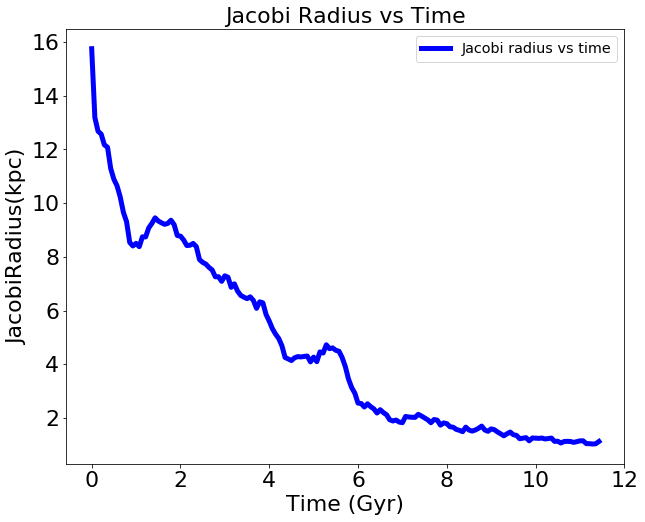

In [12]:
# Plot the Jacobi Radius vs Time simulation 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the separtion of M31 and MW
ax.plot(M33JB_profile['t']/1e3, M33JB_profile['Ms'], color='blue', linewidth=5, label='Jacobi radius vs time')


# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('JacobiRadius(kpc)', fontsize=22)

# Set the title
ax.set_title("Jacobi Radius vs Time", fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('JacobiRadiusVSTime.pdf')

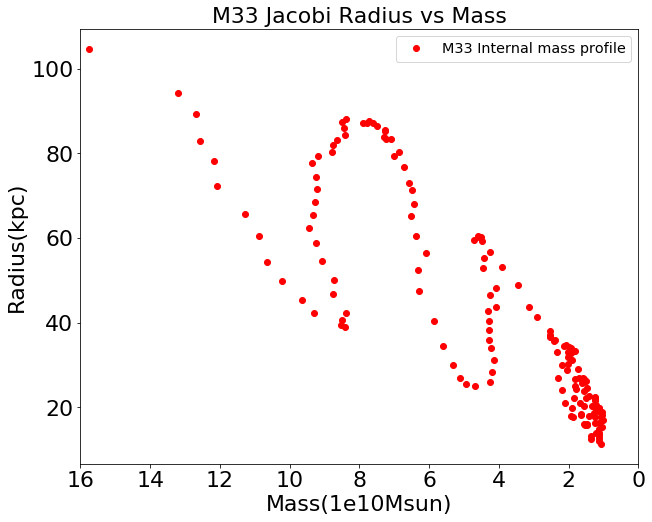

In [8]:
# Plot the Jacobi Radius vs Jacobi Mass simulation 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the separtion of M31 and MW
ax.plot(M33JB_profile['Ms'], M33JB_profile['r_jb'], 'ro', linewidth=5, label='M33 Internal mass profile')


# Add axis labels
plt.xlabel('Mass(1e10Msun)', fontsize=22)
plt.ylabel('Radius(kpc)', fontsize=22)

# Set the title
ax.set_title("M33 Jacobi Radius vs Mass", fontsize=22)

ax.set(xlim=(16, 0))
#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('M33JacobiRadiusVSMass.pdf')

In [18]:
#Here I have picked 4 examples from VLowRes document, 
#they are snapshots:0,300,600,800
S0 = MassProfile('./simple_mp/M33S1',0)
S300 = MassProfile('./simple_mp/M33S4',0)
S600 = MassProfile('./simple_mp/M33S7',0)
S800 = MassProfile('./simple_mp/M33S9',0)

In [22]:
# Create an array to store Radius, from 0-50 kpc
# intervals of 0.5 kpc
R = np.arange(0.1,100,0.5)

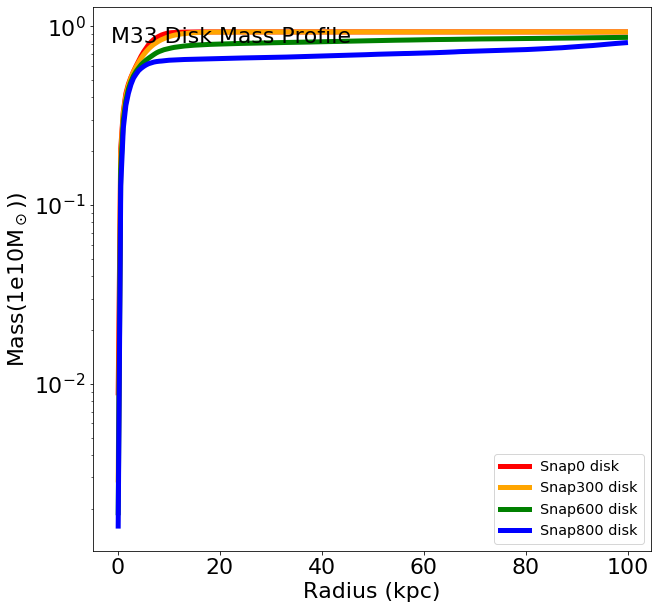

In [23]:
# Plot the internal disk Mass Profile for M31.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for disk for Snaoshot0
plt.semilogy(R,S0.MassEnclosed(2,R)/1e10, color='red', linewidth=5, label='Snap0 disk')


# Plot mass enclosed for disk for Snaoshot300
plt.semilogy(R,S300.MassEnclosed(2,R)/1e10, color='orange', linewidth=5, label='Snap300 disk')


# Plot mass enclosed for disk for Snaoshot600
plt.semilogy(R,S600.MassEnclosed(2,R)/1e10, color='green', linewidth=5, label='Snap600 disk')

# Plot mass enclosed for disk for Snaoshot800
plt.semilogy(R,S800.MassEnclosed(2,R)/1e10, color='blue', linewidth=5, label='Snap800 disk')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M33 Disk Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_M33Disk.pdf', rasterized=True, dpi=350)

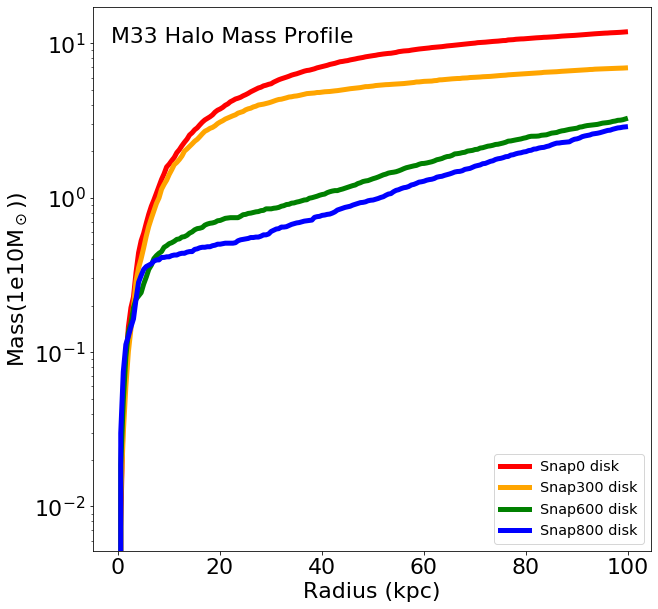

In [24]:
# Plot the halo Mass Profile for M31.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for disk for Snaoshot0
plt.semilogy(R,S0.MassEnclosed(1,R)/1e10, color='red', linewidth=5, label='Snap0 disk')


# Plot mass enclosed for disk for Snaoshot300
plt.semilogy(R,S300.MassEnclosed(1,R)/1e10, color='orange', linewidth=5, label='Snap300 disk')


# Plot mass enclosed for disk for Snaoshot600
plt.semilogy(R,S600.MassEnclosed(1,R)/1e10, color='green', linewidth=5, label='Snap600 disk')

# Plot mass enclosed for disk for Snaoshot800
plt.semilogy(R,S800.MassEnclosed(1,R)/1e10, color='blue', linewidth=5, label='Snap800 disk')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M33 Halo Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_M33Halo.pdf', rasterized=True, dpi=350)

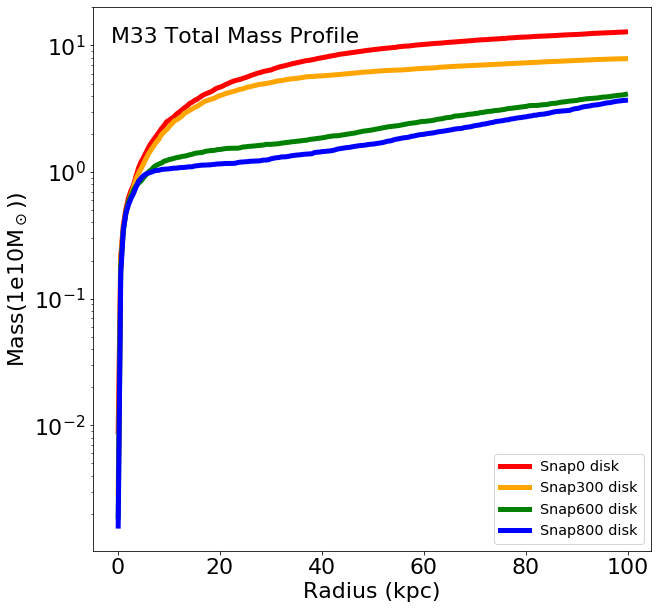

In [27]:
# Plot the M33 toal Mass Profile for M31.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mass enclosed for disk for Snaoshot0
plt.semilogy(R,S0.MassEnclosedTotal(R)/1e10, color='red', linewidth=5, label='Snap0 disk')


# Plot mass enclosed for disk for Snaoshot300
plt.semilogy(R,S300.MassEnclosedTotal(R)/1e10, color='orange', linewidth=5, label='Snap300 disk')


# Plot mass enclosed for disk for Snaoshot600
plt.semilogy(R,S600.MassEnclosedTotal(R)/1e10, color='green', linewidth=5, label='Snap600 disk')

# Plot mass enclosed for disk for Snaoshot800
plt.semilogy(R,S800.MassEnclosedTotal(R)/1e10, color='blue', linewidth=5, label='Snap800 disk')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
plt.figtext(0.15, 0.83, 'M33 Total Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('MassProfile_M33.pdf', rasterized=True, dpi=350)